In [35]:
import os, sys
import json
import pandas as pd
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import gensim
from gensim import corpora
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import permutation_importance

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Constructed Dataset

In [8]:
all_abstracts = pd.read_csv(path + "all-abstracts-labeled.csv")
all_abstracts

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title,abstract,authors,institutions,conference,date,industry
0,"""I Can’t Reply with That"": Characterizing Prob...","In email interfaces, providing users with repl...","['Ronald Robertson', 'Alexandra Olteanu', 'Fer...",Microsoft,CHI Conference on Human Factors in Computing S...,2021-05-01,True
1,"""The human body is a black box"": supporting cl...",Machine learning technologies are increasingly...,"['Mark Sendak', 'Madeleine Clare Elish', 'Mich...","['Duke Institute for Health Innovation', 'Data...",FAT* '20: Proceedings of the 2020 Conference o...,January 2020,False
2,“I Don't Want Someone to Watch Me While I'm Wo...,Employers are increasingly using information a...,"['Luke Stark', 'Amanda Stanhaus', 'Denise L. A...",Microsoft,Journal of the Association for Information Sci...,2020-03-10,True
3,50 Years of Test (Un)fairness: Lessons for Mac...,Quantitative definitions of what is unfair and...,"['Ben Hutchinson', 'Margaret Mitchell']","['Google', 'Google']",FAT* '19: Proceedings of the Conference on Fai...,January 2019,True
4,50 Years of Test (Un)fairness: Lessons for Mac...,Quantitative definitions of what is unfair and...,['Ben Hutchinson'],Google,Proceedings of FAT* 2019.,2019,True
...,...,...,...,...,...,...,...
314,"Whose side are ethics codes on?: power, respon...",The moral authority of ethics codes stems from...,"['Anne L. Washington', 'Rachel Kuo']","['New York University', 'New York University']",FAT* '20: Proceedings of the 2020 Conference o...,January 2020,False
315,Whose tweets are surveilled for the police: an...,Social media monitoring by law enforcement is ...,"['Glencora Borradaile', 'Brett Burkhardt', 'Al...","['Oregon State University', 'Oregon State Univ...",FAT* '20: Proceedings of the 2020 Conference o...,January 2020,False
316,Why does my model fail?: contrastive local exp...,"In various business settings, there is an inte...","['Ana Lucic', 'Hinda Haned', 'Maarten de Rijke']","['University of Amsterdam, Amsterdam, Netherla...",FAT* '20: Proceedings of the 2020 Conference o...,January 2020,True
317,Why Reliabilism Is Not Enough:Epistemic and Mo...,In this paper we argue that standard calls for...,['Ben Hutchinson'],Google,AIES 2020 (2020),2020,True


In [10]:
path = "data/"
all_abstracts = pd.read_csv(path + "all-abstracts-labeled.csv")
industry = list(all_abstracts[all_abstracts['industry'] == True]['abstract'])
academia = list(all_abstracts[all_abstracts['industry'] == False]['abstract'])
full_dataset = industry + academia

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topic Modeling

In [12]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

academia_clean = [clean(doc).split() for doc in academia]
industry_clean = [clean(doc).split() for doc in industry]
full_clean = [clean(doc).split() for doc in full_dataset]

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
academia_dict = corpora.Dictionary(academia_clean)
industry_dict = corpora.Dictionary(industry_clean)
full_dict = corpora.Dictionary(full_clean)
academia_term_matrix = [academia_dict.doc2bow(doc) for doc in academia_clean]
industry_term_matrix = [industry_dict.doc2bow(doc) for doc in industry_clean]
full_term_matrix = [full_dict.doc2bow(doc) for doc in full_clean]

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Word cloud

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


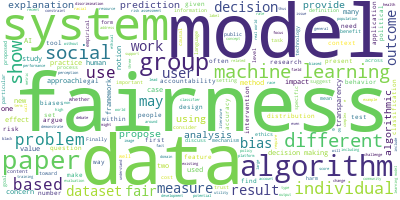

In [14]:
# Academia wordcloud
long_string = ','.join(list(academia))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


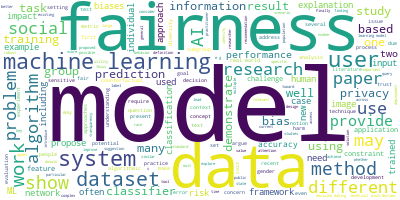

In [15]:
# Industry wordcloud
long_string = ','.join(list(industry))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


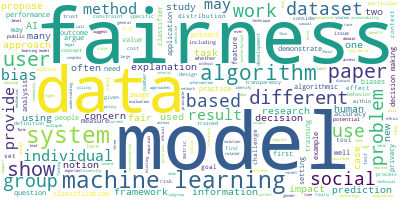

In [16]:
# Entire dataset wordcloud
long_string = ','.join(list(full_dataset))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

### TF-IDF reweighting

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


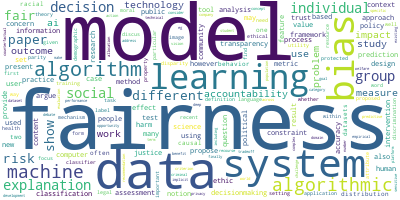

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

# convert each doc to strings
academia_clean_doc = [" ".join(doc) for doc in academia_clean]
industry_clean_doc = [" ".join(doc) for doc in industry_clean]

vectorizer = TfidfVectorizer()
academia_tfidf = vectorizer.fit_transform(academia_clean_doc)
feature_names = vectorizer.get_feature_names()

academia_dense = academia_tfidf.todense()
denselist = academia_dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names).transpose().sum(axis=1)

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate_from_frequencies(df)
wordcloud.to_image()

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


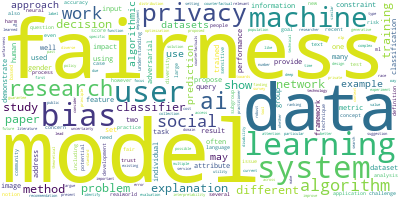

In [61]:
vectorizer = TfidfVectorizer()
industry_tfidf = vectorizer.fit_transform(industry_clean_doc)
feature_names = vectorizer.get_feature_names()

industry_dense = industry_tfidf.todense()
denselist = industry_dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names).transpose().sum(axis=1)

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate_from_frequencies(df)
wordcloud.to_image()

## LDA visualization

In [94]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import seaborn as sns
sns.set_theme()

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perform topic visualization on entire dataset. Compare coherence for topic #s 2-5.

In [90]:
# Full Dataset
lda2 = LdaModel(full_term_matrix, num_topics=2, id2word=full_dict, passes=50)
lda3 = LdaModel(full_term_matrix, num_topics=3, id2word=full_dict, passes=50)
lda4 = LdaModel(full_term_matrix, num_topics=4, id2word=full_dict, passes=50)
lda5 = LdaModel(full_term_matrix, num_topics=5, id2word=full_dict, passes=50)
lda6 = LdaModel(full_term_matrix, num_topics=6, id2word=full_dict, passes=50)

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Coherence scores')

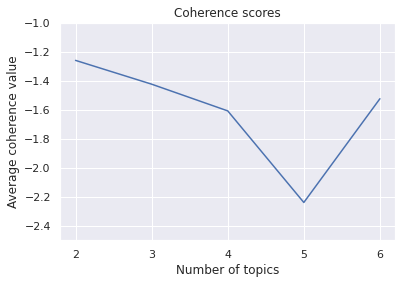

In [99]:
# get coherence of the different lda models
cm = CoherenceModel.for_models([lda2, lda3, lda4, lda5, lda6], full_dict, corpus=full_term_matrix, coherence='u_mass')
coherence_vals = [tup[1] for tup in cm.compare_models([lda2, lda3, lda4, lda5, lda6])]
plt.plot(np.array([2, 3, 4, 5, 6]), coherence_vals)
plt.ylim(-2.5, -1)
plt.xticks(np.arange(2, 7, step=1))
plt.xlabel("Number of topics")
plt.ylabel("Average coherence value")
plt.title("Coherence scores")

In [104]:
open("./figures/lda_vis.html", "w")

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<_io.TextIOWrapper name='./figures/lda_vis.html' mode='w' encoding='UTF-8'>

In [106]:
lda_display = gensimvis.prepare(lda2, full_term_matrix, full_dict, R=15, sort_topics=False)
pyLDAvis.save_html(lda_display, open("./figures/lda_vis.html", "w"))
pyLDAvis.display(lda_display)

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


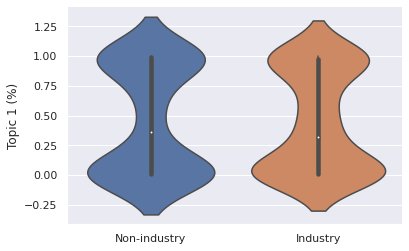

In [226]:
# Examine topic distribution among industry & academic papers
aca_docs = [full_dict.doc2bow(doc) for doc in academia_clean]
industry_docs = [full_dict.doc2bow(doc) for doc in industry_clean]

# for i in range(len(full_term_matrix)):
#     print(lda2.get_document_topics(full_term_matrix[i]))

# visualize in topic space
acad_pts = []
industry_pts = []
labels = []

def generate_point(topic_dist):
    primary_topic = topic_dist[0][0]
    pct_topic = topic_dist[0][1]
    point = [0, 0]
    point[primary_topic] = pct_topic
    point[1 - primary_topic] = 1 - pct_topic
    return point

for i in range(len(aca_docs)):
    topic_dist = lda2.get_document_topics(aca_docs[i])
    acad_pts.append(generate_point(topic_dist))
    labels.append("Non-industry")
    
for i in range(len(industry_docs)):
    topic_dist = lda2.get_document_topics(industry_docs[i])
    industry_pts.append(generate_point(topic_dist))
    labels.append("Industry")
    
# restrict to topic 1
topic_1 = np.array(acad_pts + industry_pts)[:, 0]

ax = sns.violinplot(x=labels, y=topic_1, jitter=0.2)
ax.set(ylabel="Topic 1 (%)")
sns.despine()

In [63]:
# # Academia
# ldamodel = LdaModel(academia_term_matrix, num_topics=3, id2word=academia_dict, passes=50)
# lda_display = gensimvis.prepare(ldamodel, academia_term_matrix, academia_dict, sort_topics=False)
# pyLDAvis.display(lda_display)

# # Industry
# ldamodel = LdaModel(industry_term_matrix, num_topics=5, id2word=industry_dict, passes=50)
# lda_display = gensimvis.prepare(ldamodel, industry_term_matrix, industry_dict, sort_topics=False)
# pyLDAvis.display(lda_display)

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Binary Classification

In [184]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, plot_roc_curve, roc_curve, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, f1_score, make_scorer, balanced_accuracy_score
from sklearn.base import clone
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
import warnings
warnings.filterwarnings('ignore') 

In [134]:
x_academia = academia
y_academia = [0]*len(x_academia)
x_industry = industry
y_industry = [1]*len(x_industry)
X = x_academia + x_industry
y = y_academia + y_industry

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

In [175]:
# define featurizers
featurizers = {
    "tfidf": TfidfVectorizer(),
    "bow": CountVectorizer(),
}

# define classifiers
classifiers = {
    "logistic regression": LogisticRegression(),
    "multinomial nb": MultinomialNB(),
    "svc": SVC(),
}

param_grids = {
    "logistic regression": {
        "clf__C" : [100, 10, 1, 1e-1]
    },
    "multinomial nb": {
        "clf__alpha": np.linspace(0.5, 1.5, 6),
        "clf__fit_prior": [True, False],  
    },
    "svc": {
        'clf__C': np.logspace(-1, 3, base = 10, num=4),  
        'clf__gamma': [1, 0.1, 0.01], 
    }
}

scoring = {
    'acc': 'accuracy',
    'balanced_acc': 'balanced_accuracy',
    'pos_prec': 'precision',
    'pos_rec': 'recall',
    'f1': 'f1',
    'auc_roc': 'roc_auc'
}

# utils for printing performance
def mean_and_std(scores):
    """ Return string with mean & stdev"""
    arr = np.array(scores)
    return f"{arr.mean():0.4f} (SD: {arr.std():0.4f})" 

def print_scores(scores, num_folds=5):
    print()
    print("Validation statistics of best model")
    print("-----------------------")
    print(f"{num_folds}-fold CV Val Accuracy:\t\t{mean_and_std(scores['test_acc'])}")
    print(f"{num_folds}-fold CV Val Balanced Accuracy:\t\t{mean_and_std(scores['test_balanced_acc'])}")
    print(f"{num_folds}-fold CV Val Precision (Industry):\t\t{mean_and_std(scores['test_pos_prec'])}")
    print(f"{num_folds}-fold CV Val Recall (Industry):\t\t{mean_and_std(scores['test_pos_rec'])}")
    print(f"{num_folds}-fold CV Val F1:\t\t{mean_and_std(scores['test_f1'])}")
    print(f"{num_folds}-fold CV Val ROC AUC:\t\t{mean_and_std(scores['test_auc_roc'])}")
    print()
    print("Training statistics of best model")
    print("-----------------------")
    print(f"{num_folds}-fold CV Train Accuracy:\t\t{mean_and_std(scores['train_acc'])}")
    print(f"{num_folds}-fold CV Train Balanced Accuracy:\t\t{mean_and_std(scores['train_balanced_acc'])}")
    print(f"{num_folds}-fold CV Train Precision (Industry):\t\t{mean_and_std(scores['train_pos_prec'])}")
    print(f"{num_folds}-fold CV Train Recall (Industry):\t\t{mean_and_std(scores['train_pos_rec'])}")
    print(f"{num_folds}-fold CV Train F1:\t\t{mean_and_std(scores['train_f1'])}")
    print(f"{num_folds}-fold CV Train ROC AUC:\t\t{mean_and_std(scores['train_auc_roc'])}")
    print()

Training logistic regression classifier using tfidf featurizer...

Validation statistics of best model
-----------------------
5-fold CV Val Accuracy:		0.6641 (SD: 0.1014)
5-fold CV Val Balanced Accuracy:		0.6468 (SD: 0.1025)
5-fold CV Val Precision (Industry):		0.6996 (SD: 0.1039)
5-fold CV Val Recall (Industry):		0.7536 (SD: 0.1097)
5-fold CV Val F1:		0.7223 (SD: 0.0926)
5-fold CV Val ROC AUC:		0.6731 (SD: 0.1499)

Training statistics of best model
-----------------------
5-fold CV Train Accuracy:		1.0000 (SD: 0.0000)
5-fold CV Train Balanced Accuracy:		1.0000 (SD: 0.0000)
5-fold CV Train Precision (Industry):		1.0000 (SD: 0.0000)
5-fold CV Train Recall (Industry):		1.0000 (SD: 0.0000)
5-fold CV Train F1:		1.0000 (SD: 0.0000)
5-fold CV Train ROC AUC:		1.0000 (SD: 0.0000)

Best CV parameters:
{'clf__C': 100}

Accuracy score (entire train set): 1.0
Confusion matrix (training set):
[[26  0]
 [ 0 37]]

Training multinomial nb classifier using tfidf featurizer...

Validation statistics of

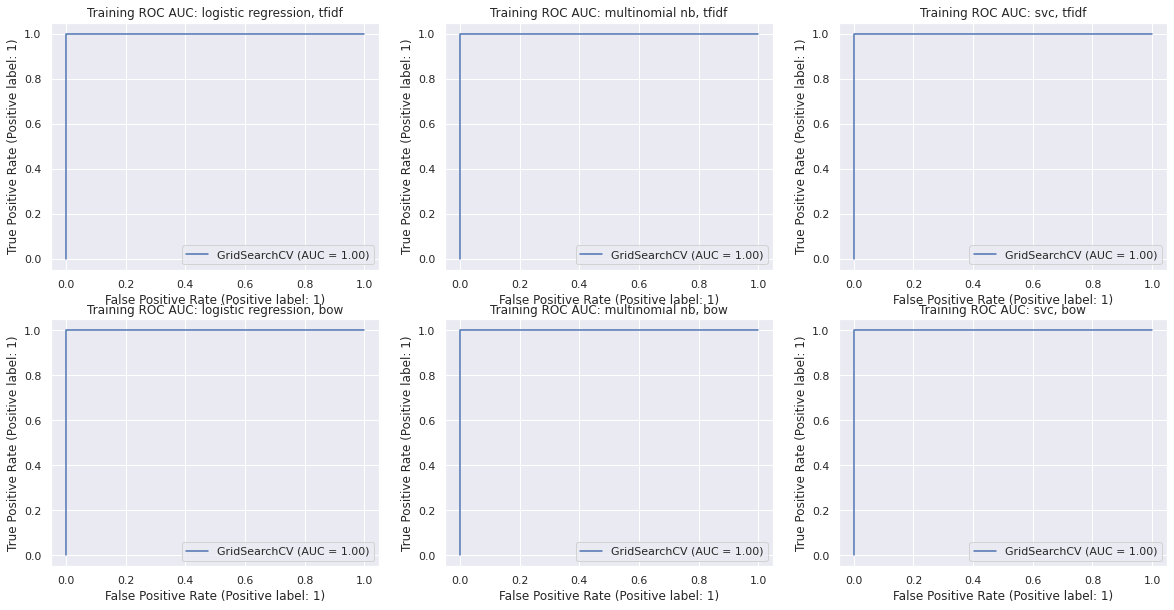

In [177]:
# refit based on highest accuracy
refit='acc'
models = {} # store best performing models

plt.figure(1, figsize=(20,10))
rows = len(featurizers)
cols = len(classifiers)
num_folds = 5
plotnum = 0
for fname, f in featurizers.items():
    for cname, c in classifiers.items():
        print(f"Training {cname} classifier using {fname} featurizer...")
        # construct pipeline of vectorizer and classifier
        pipeline = Pipeline([('vec', f),('clf', c)])
        
        # perform CV grid search
        clf = GridSearchCV(pipeline, param_grids[cname], cv=num_folds, scoring=scoring, refit=refit, return_train_score=True)
        clf.fit(X_train, y_train)
        # store fitted best model
        models[(fname, cname)] = clf
        
        # get cross validated scores for the best estimator
        scores = cross_validate(clone(clf.best_estimator_), X_train, y_train, cv=num_folds, scoring=scoring, return_train_score=True)
        print_scores(scores, num_folds=num_folds)
        print("Best CV parameters:")
        print(clf.best_params_)
        
        # plot training ROC AUC
        plotnum += 1
        ax = plt.subplot(rows, cols, plotnum)
        disp = plot_roc_curve(clf, X_train, y_train, ax=ax)
        disp.ax_.set_title(f"Training ROC AUC: {cname}, {fname}")
        
        # display metrics of interest on full training data set
        prediction = clf.predict(X_train)
        print()
        print(f"Accuracy score (entire train set): {accuracy_score(y_train, prediction)}")
        print("Confusion matrix (training set):")
        # Rows = true labels
        # Cols = predicted labels
        print(confusion_matrix(y_train, prediction))
        print()

In [178]:
# inspect logistic BOW

model = models[("bow", "logistic regression")].best_estimator_


feature_names = (model.named_steps['vec']
                      .get_feature_names())

coefs = pd.DataFrame(
    np.array(model.named_steps['clf'].coef_).flatten(),
    columns=['Coefficients'], index=feature_names
)

print("\nMost predictive of industry:")
print(coefs['Coefficients'].nlargest(10))

print("\nMost predictive of academia:")
print(coefs['Coefficients'].nsmallest(10))


Most predictive of industry:
model          0.442460
users          0.400223
these          0.378700
feature        0.368726
attribute      0.362130
may            0.355483
research       0.340702
exploration    0.337932
training       0.327571
then           0.308772
Name: Coefficients, dtype: float64

Most predictive of academia:
of           -0.650054
fairness     -0.474906
our          -0.459232
fair         -0.429661
decision     -0.422632
out          -0.411254
related      -0.396130
public       -0.384385
embeddings   -0.384323
leave        -0.376096
Name: Coefficients, dtype: float64


In [179]:
# find highest accuracy models

# find acc_model with highest validation accuracy
name_and_models = [(k, v) for k, v in models.items()]
top_n = 2
best_acc_models = sorted(name_and_models, key=lambda tup: -1 * tup[1].best_score_)[:top_n]

for bm in best_acc_models:
    print(f"{bm[0]} validation accuracy: {bm[1].best_score_}")

('bow', 'logistic regression') validation accuracy: 0.714102564102564
('tfidf', 'logistic regression') validation accuracy: 0.6641025641025642


Model and featurizer: ('bow', 'logistic regression')
Accuracy score: 0.6640625
Balanced accuracy score: 0.6531986531986532
F1: 0.7278481012658228

Model and featurizer: ('tfidf', 'logistic regression')
Accuracy score: 0.65625
Balanced accuracy score: 0.6483624119987756
F1: 0.7086092715231789



Text(0.5, 1.0, 'Test Set ROC of Final Models')

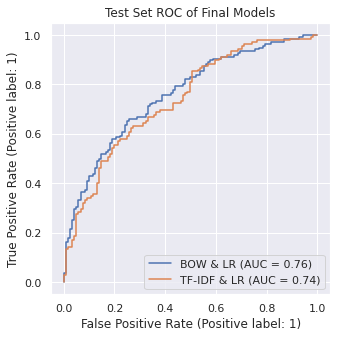

In [185]:
fig, ax = plt.subplots(figsize=(5, 5))

label_map = {
    ('bow', 'logistic regression'): 'BOW & LR',
    ('tfidf', 'logistic regression'): 'TF-IDF & LR'
}

for bm in best_acc_models:
    model = bm[1].best_estimator_
    print(f"Model and featurizer: {bm[0]}")
    
    prediction = model.predict(X_test)
    print(f"Accuracy score: {accuracy_score(y_test, prediction)}")
    print(f"Balanced accuracy score: {balanced_accuracy_score(y_test, prediction)}")
    print(f"F1: {f1_score(y_test, prediction)}")
    disp = plot_roc_curve(model, X_test, y_test, ax=ax, name=label_map[bm[0]])

    print()

ax.set_title("Test Set ROC of Final Models")